# EfficientNet-B0

<img src="https://github.com/drmoon-1st/Paper-Implementation/blob/main/CondConv:%20Conditionally%20Parameterized%20Convolutions%20for%20Efficient%20Inference/imgs/%EC%8A%A4%ED%81%AC%EB%A6%B0%EC%83%B7,%202022-12-28%2014-42-16.png?raw=true" width=600 height=300>

## features
* globalaveragePooling -> relu
* vary hidden layer size -> input_dim/8, input_dim. input_dim*8
* Hierarchical routing functions -> concatenating the routing weights of the previous layer to the output of the global average pooling layer in the routing function
* softmax activation function to compute routing wueights
* CondConv layer
* The routing model follow a bi-modal distribution

In [1]:
# Deep Learning
import torch
import torch.nn as nn
from torch.nn import functional as F

import tensorflow as tf

# Data Visualization
import matplotlib.pyplot as plt

# others
import math

### EfficientNet-B0 in tensorflow

In [2]:
model  = tf.keras.applications.EfficientNetB0(weights='imagenet')
model.summary()

2022-12-28 20:28:17.789349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 20:28:17.793908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 20:28:17.794077: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-28 20:28:17.795079: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

### swish

<img src="https://jesuisjavert.github.io/gallery/post/tensorflow/tensorflow13.png" width=600 height=300>

* what is swish?
 * swish(x) = x * sigmoid(x)
 * relu를 대체하기 위해 구글이 고안한 함수
 * sigmoid 함수에 x를 곱한 형태
 * 깊은 layer을 학습시킬 때 더욱 뛰어난 성능을 보임

In [3]:
def swish(x):
    return x * torch.sigmoid(x)

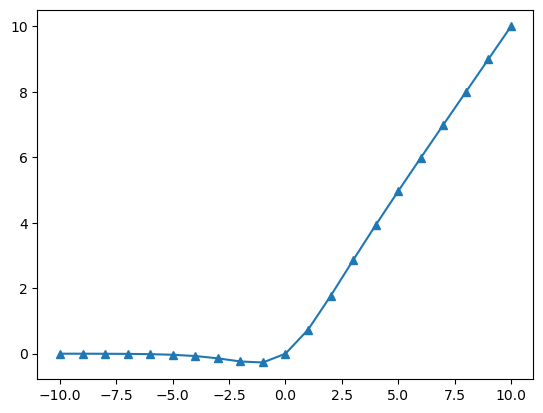

In [4]:
X = [x for x in range(-10, 11)]
y = [swish(torch.tensor([x])).item() for x in X]

plt.plot(X, y, '-^')

### Conv 2D

In [5]:
class Conv2dsamepadding(nn.Conv2d):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, 
                 dilation=1, groups=1, bias=True):
        super().__init__(in_planes, out_planes, kernel_size, stride, 0, dilation, groups, bias)
        
    def forward(self, x):
        ih, iw = x.size()[-2:]
        kh, kw = self.weight.size()[-2:]
        sh, sw = self.stride
        oh, ow = math.ceil(ih / sh), math.ceil(iw / sw)
        pad_h = max((oh - 1) * self.stride[0] + (kh - 1) * self.dilation[0] + 1 - ih, 0)
        pad_w = max((ow - 1) * self.stride[1] + (kw - 1) * self.dilation[1] + 1 - iw, 0)
        if pad_h > 0 or pad_w > 0:
            x = F.pad(x, [pad_w//2, pad_w - pad_w//2, pad_h//2, pad_h - pad_h//2])
        return F.conv2d(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

### Drop Connect

In [6]:
def drop_connect(inputs, p, training):
    if not training:return inputs
    batch_size = inputs.shape[0]
    keep_prop = 1 - p
    random_tensor = keep_prop
    random_tensor += torch.rand([batch_size, 1, 1, 1], dtype=inputs.dtype)
    binary_tensor = torch.floor(random_tensor)
    output = inputs / keep_prop * binary_tensor
    return output

### MBConvBlock(MobileNet)

In [7]:
class MBConvBlock(nn.Module):
    def __init__(self, kernel_size, stride, expand_ratio, input_filters, output_filters, se_ratio, drop_n_add):
        super().__init__()
        
        self._bn_mom = 0.1
        self._bn_eps = 1e-03
        self.has_se = (se_ratio is not None) and (0 < se_ratio <= 1)
        self.expand_ratio = expand_ratio
        self.drop_n_add = drop_n_add

        inp = input_filters
        oup = input_filters * expand_ratio
        if expand_ratio != 1:
            self._expand_conv = Conv2dsamepadding(inp, oup, kernel_size=1, bias=False)
            self.bn0 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
            
        k = kernel_size
        s = stride
        self._depthwise_conv = Conv2dsamepadding(
        oup, oup, groups=oup, kernel_size=k, stride=s, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=oup, momentum=self._bn_mom, eps=self._bn_eps)
        
        if self.has_se:
            num_squeezed_channels = max(1, int(input_filters * se_ratio))
            self._se_reduce = Conv2dsamepadding(oup, num_squeezed_channels, kernel_size=1)
            self._se_expand = Conv2dsamepadding(num_squeezed_channels, oup, kernel_size=1)
            
        final_oup = output_filters
        self._project_conv = Conv2dsamepadding(oup, oup, kernel_size=1, bias=False)
        self._bn2 = nn.BatchNorm2d(num_features=final_oup, momentum=self._bn_mom, eps=self._bn_eps)
        
    def forward(self, inputs, drop_connect_rate=0.2):
        x = inputs
        if self.expand_ratio != 1:
            x = self._expand_conv(x)
            x = self.bn0(x)
            x = swish(x)
        x = self._depthwise_conv(x)
        x = self.bn1(x)
        x = swish(x)
        
        if self.has_se:
            x_squeezed = F.adaptive_avg_pool2d(x, 1)
            x_squeezed = self._se_reduce(x_squeezed)
            x_squeezed = swish(x_squeezed)
            x_squeezed = self._se_expand(x_squeezed)
            x = torch.sigmoid(x_squeezed) * x
            
        x = self._project_conv(x)
        x = self._bn2(x)
        
        if self.drop_n_add:
            if drop_connect_rate:
                x = drop_connect(x, p=drop_connect_rate, training=self.training)
            x = x + inputs
        return x

### EfficientNetB0

In [8]:
class EfficientNetB0(nn.Module):
    def __init__(self):
        super().__init__()
        bn_mom = 0.1
        bn_eps = 1e-03
        
        in_channels = 3
        out_channels = 32
        self._conv_stem = Conv2dsamepadding(in_channels, out_channels, kernel_size=3, stride=2, bias=False)
        self._bn0 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        
        self._blocks = nn.ModuleList([])
        self._blocks.append(MBConvBlock(kernel_size=3, stride=1, expand_ratio=1, input_filters=32, output_filters=16, 
                                        se_ratio=0.25, drop_n_add=False))
        self._blocks.append(MBConvBlock(3, 2, 6, 16, 24, 0.25, False))
        self._blocks.append(MBConvBlock(3, 1, 6, 24, 24, 0.25, True))
        self._blocks.append(MBConvBlock(5, 2, 6, 24, 40, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 40, 40, 0.25, True))
        self._blocks.append(MBConvBlock(3, 2, 6, 40, 80, 0.25, False))
        self._blocks.append(MBConvBlock(3, 1, 6, 80, 80, 0.25, True))
        self._blocks.append(MBConvBlock(3, 1, 6, 80, 80, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 80, 112, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 112, 112, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 112, 112, 0.25, True))
        self._blocks.append(MBConvBlock(5, 2, 6, 112, 192, 0.25, False))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        self._blocks.append(MBConvBlock(5, 1, 6, 192, 192, 0.25, True))
        self._blocks.append(MBConvBlock(3, 1, 6, 192, 320, 0.25, False))
        
        in_channels = 320
        out_channels = 1280
        self._conv_head = Conv2dsamepadding(in_channels, out_channels, kernel_size=1, bias=False)
        self._bn1 = nn.BatchNorm2d(num_features=out_channels, momentum=bn_mom, eps=bn_eps)
        
        self._dropout = 0.2
        self._num_classes = 10
        self._fc = nn.Linear(out_channels, self._num_classes)
        
    def extract_features(self, x):
        x = self._conv_stem(x)
        x = self.bn0(x)
        x = swish(x)
        
        for idx, block in enumerate(self._blocks):
            x = block(x)
        return x
    
    def forward(self, x):
        x = self.extract_features(x)
        x = self._conv_head(x)
        x = self.bn1(x)
        x = swish(x)
        x = F.adaptive_avg_pool2d(x, 1).squeeze(-1).squeeze(-1)
        if self._dropout:
            x = F.dropout(x, p=self._dropout, training=self.training)
        x = self._fc(x)
        return x

코드 출처 : https://startnow95.tistory.com/4